In [1]:
import os
import gc
import torch
os.chdir("/work/pi_jensen_umass_edu/jnainani_umass_edu/CircuitAnalysisSAEs")
import json
from sae_lens import SAE, HookedSAETransformer
from circ4latents import data_gen
from functools import partial
import einops

# Function to manage CUDA memory and clean up
def cleanup_cuda():
   torch.cuda.empty_cache()
   gc.collect()
# cleanup_cuda()
# Load the config
with open("config.json", 'r') as file:
   config = json.load(file)
token = config.get('huggingface_token', None)
os.environ["HF_TOKEN"] = token

# Define device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

hf_cache = "/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/huggingface_cache/hub"
os.environ["HF_HOME"] = hf_cache

# Load the model
model = HookedSAETransformer.from_pretrained("google/gemma-2-9b", device=device, cache_dir=hf_cache)

layers= [7, 14, 21, 40]
saes = [SAE.from_pretrained(release="gemma-scope-9b-pt-res-canonical", sae_id=f"layer_{layer}/width_16k/canonical", device=device)[0] for layer in layers]

/work/pi_jensen_umass_edu/jnainani_umass_edu/mechinterp/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Device: cuda


Loading checkpoint shards: 100%|██████████| 8/8 [00:00<00:00,  9.25it/s]


Loaded pretrained model google/gemma-2-9b into HookedTransformer


In [2]:
# Updated version to return JSON with more names and structure for correct and incorrect keying examples

import json
import random

# Expanding the name pool with a larger set of names
extended_name_pool = [
    "Bob", "Sam", "Lilly", "Rob", "Alice", "Charlie", "Sally", "Tom", "Jake", "Emily", 
    "Megan", "Chris", "Sophia", "James", "Oliver", "Isabella", "Mia", "Jackson", 
    "Emma", "Ava", "Lucas", "Benjamin", "Ethan", "Grace", "Olivia", "Liam", "Noah"
]

for name in extended_name_pool:
    assert len(model.tokenizer.encode(name)) == 2, f"Name {name} has more than 1 token"

# Function to generate the dataset with correct and incorrect keying into dictionaries
def generate_extended_dataset(name_pool, num_samples=5):
    dataset = []
    
    for _ in range(num_samples):
        # Randomly select 5 names from the pool
        selected_names = random.sample(name_pool, 5)
        # Assign random ages to the selected names
        age_dict = {name: random.randint(10, 19) for name in selected_names}
        
        # Create a correct example
        correct_name = random.choice(list(age_dict.keys()))
        correct_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{correct_name}"]\n'
        correct_response = age_dict[correct_name]
        correct_token = str(correct_response)[0]
        
        # Create an incorrect example with a name not in the dictionary
        incorrect_name = random.choice([name for name in name_pool if name not in age_dict])
        incorrect_prompt = f'Type "help", "copyright", "credits" or "license" for more information.\n>>> age = {age_dict}\n>>> age["{incorrect_name}"]\n'
        incorrect_response = "Traceback"
        incorrect_token = "Traceback"
        
        # Append the pair of correct and incorrect examples
        dataset.append({
            "correct": {
                "prompt": correct_prompt,
                "response": correct_response,
                "token": correct_token
            },
            "error": {
                "prompt": incorrect_prompt,
                "response": incorrect_response,
                "token": incorrect_token
            }
        })
        
    return dataset

# Generate the extended dataset
json_dataset = generate_extended_dataset(extended_name_pool, num_samples=100_000)

clean_prompts = []
corr_prompts = []

answer_token = model.to_single_token("1")
traceback_token = model.to_single_token("Traceback")

for item in json_dataset[:50]:
    corr_prompts.append(item["correct"]["prompt"])
    clean_prompts.append(item["error"]["prompt"])

clean_tokens = model.to_tokens(clean_prompts)
corr_tokens = model.to_tokens(corr_prompts)

In [3]:
def logit_diff_fn(logits):
    err = logits[:, -1, traceback_token]
    no_err = logits[:, -1, answer_token]
    return (err - no_err).mean()

# Disable gradients for all parameters
for param in model.parameters():
   param.requires_grad_(False)

# # Compute logits for clean and corrupted samples
logits = model(clean_tokens)
clean_diff = logit_diff_fn(logits)

logits = model(corr_tokens)
corr_diff = logit_diff_fn(logits)

print(f"clean_diff: {clean_diff}")
print(f"corr_diff: {corr_diff}")

# # Cleanup
del logits
cleanup_cuda()

# # Define error type metric
def _err_type_metric(logits, clean_logit_diff, corr_logit_diff):
    patched_logit_diff = logit_diff_fn(logits)
    return (patched_logit_diff - corr_logit_diff) / (clean_logit_diff - corr_logit_diff)

err_metric_denoising = partial(_err_type_metric, clean_logit_diff=clean_diff, corr_logit_diff=corr_diff)

clean_diff: 6.987605571746826
corr_diff: -6.887427806854248


In [4]:
def run_with_saes_filtered_cache(tokens, filtered_ids, model, saes):
    with torch.no_grad():  # Global no_grad for performance
        
        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Equivalent to unsqueeze(-1)

        sae_outs = {}
        
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Apply torch.where only if mask_expanded has True values
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_outs


def run_with_saes_latent_op_patch(new_tokens, filtered_ids, model, saes, cache, dict_feats):
   # Ensure tokens are a torch.Tensor
   if not isinstance(new_tokens, torch.Tensor):
       new_tokens = torch.tensor(new_tokens).to(model.cfg.device)  # Move to the device of the model

   # Create a mask where True indicates positions to modify
   mask = torch.ones_like(new_tokens, dtype=torch.bool)
   for token_id in filtered_ids:
       mask &= new_tokens != token_id

   # Expand the mask once, so it matches the shape [batch_size, seq_len, 1]
   mask_expanded = mask.unsqueeze(-1)  # Expand to allow broadcasting
   mask_expanded = mask_expanded.to(model.cfg.device)  # Move the mask to the same device as the model
   # For each SAE, add the appropriate hook
   for sae in saes:
       hook_point = sae.cfg.hook_name

       # Define the filtered hook function (optimized)
       def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
           # Apply the SAE only where mask_expanded is True
           enc_sae = sae.encode(act)  # Call the SAE once
          
           if hook.name in cache and hook.name in dict_feats:
               prev_sae = cache[hook.name].to(device)   # Get cached activations from the cache
               feature_indices = dict_feats[hook.name]  # Get the feature indices to patch

               for feature_idx in range(sae.cfg.d_sae):
                   if feature_idx in feature_indices:
                       enc_sae[:, :, feature_idx] = prev_sae[:, :, feature_idx]

           # After patching, decode the modified enc_sae
           modified_act = sae.decode(enc_sae)

           # In-place update where the mask is True
           updated_act = torch.where(mask_expanded, modified_act, act)

           return updated_act

       # Add the hook to the model
       model.add_hook(hook_point, filtered_hook, dir='fwd')

   # Run the model with the tokens (no gradients needed)
   with torch.no_grad():
       logits = model(new_tokens)

   # Reset the hooks after computation to free memory
   model.reset_hooks()

   return logits  # Return only the logits

def run_with_saes_latent_op_patch_cache(new_tokens, filtered_ids, model, saes, cache, dict_feats):
    with torch.no_grad():  # Global no_grad for efficiency

        # Ensure new_tokens is a tensor on the correct device
        new_tokens = torch.as_tensor(new_tokens, device=model.cfg.device)
        
        # Create mask in a vectorized way
        mask = ~torch.isin(new_tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Expand dimensions directly
        
        # Cache hook names and feature indices outside the hook
        sae_hook_configs = [(sae.cfg.hook_name, sae, dict_feats.get(sae.cfg.hook_name, [])) for sae in saes]
        sae_outs = {}

        # Define and apply hooks
        for hook_name, sae, feature_indices in sae_hook_configs:
            def filtered_hook(act, hook, sae=sae, feature_indices=feature_indices, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                if hook.name in cache and feature_indices:
                    # Vectorized update of selected feature indices
                    enc_sae[:, :, feature_indices] = cache[hook.name][:, :, feature_indices].to(device) 

                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Only apply torch.where if needed
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_name, filtered_hook, dir='fwd')

        logits = model(new_tokens)
        model.reset_hooks()

    return logits, sae_outs
    
def run_with_saes_zero_ablation(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]

        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0

                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits

In [5]:
cleanup_cuda()

In [6]:
model.reset_hooks()
filtered_ids = [model.tokenizer.bos_token_id]
clean_sae_logits, clean_sae_cache = run_with_saes_filtered_cache(clean_tokens, filtered_ids, model, saes)
corr_sae_logits, corr_sae_cache = run_with_saes_filtered_cache(corr_tokens, filtered_ids, model, saes)

clean_sae_diff = logit_diff_fn(clean_sae_logits)
corr_sae_diff = logit_diff_fn(corr_sae_logits)

print(f"clean_sae_diff: {clean_sae_diff}")
print(f"corr_sae_diff: {corr_sae_diff}")

clean_sae_diff: 1.9274580478668213
corr_sae_diff: -6.57592248916626


In [7]:
with open('mask_finding/mask.json') as f:
    mask = json.load(f)

# load clustered latnets as cluster_results 
with open('mask_finding/out/clustering/clustered_latents.json') as f:
    cluster_results = json.load(f)

# load the drop results json
with open('mask_finding/out/clustering/drop_results.json') as f:
    drop_results = json.load(f)

In [8]:
model.reset_hooks()
logits = run_with_saes_zero_ablation(clean_tokens, filtered_ids, model, saes, mask)
clean_sae_diff_ablation = logit_diff_fn(logits)
print(f"clean_sae_diff_ablation: {clean_sae_diff_ablation}")

logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
corr_sae_diff_ablation = logit_diff_fn(logits)
print(f"corr_sae_diff_ablation: {corr_sae_diff_ablation}")

clean_sae_diff_ablation: 0.6343554258346558
corr_sae_diff_ablation: -1.3921657800674438


In [9]:
del logits 
cleanup_cuda()

In [10]:
# duplicate token latents are cluster 0 for layer 7 
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(duplicate_latents))
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, filtered_mask)

log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, answer_token]
print("Duplicate cluster ablated: ", log_probs.mean())

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, answer_token]
print("Full circuit perf: ", log_probs.mean())

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated:  tensor(0.3550, device='cuda:0')
Full circuit perf:  tensor(0.6806, device='cuda:0')


In [11]:
fully_filtered_mask = {'blocks.7.hook_resid_post': list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))}

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, fully_filtered_mask)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, answer_token]
print("Duplicate cluster ablated, all latents: ",log_probs.mean())

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, {})
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, answer_token]
print("All latents: ",log_probs.mean())

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  tensor(0.5986, device='cuda:0')
All latents:  tensor(0.9219, device='cuda:0')


In [12]:
# duplicate token latents are cluster 0 for layer 7 
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(duplicate_latents))
model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, filtered_mask)

log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, answer_token]
circuit_dup_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated: ", circuit_dup_ablated)

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, mask)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, answer_token]
full_circuit_perf = log_probs.mean().detach().cpu().item()
print("Full circuit perf: ", full_circuit_perf)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated:  0.3549896478652954
Full circuit perf:  0.6805824041366577


In [13]:
fully_filtered_mask = {'blocks.7.hook_resid_post': list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))}

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, fully_filtered_mask)
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, answer_token]
model_dup_ablated = log_probs.mean().detach().cpu().item()
print("Duplicate cluster ablated, all latents: ",model_dup_ablated)

model.reset_hooks()
logits = run_with_saes_zero_ablation(corr_tokens, filtered_ids, model, saes, {})
log_probs = torch.nn.functional.softmax(logits, dim=-1)
log_probs = log_probs[:, -1, answer_token]
full_model_perf = log_probs.mean().detach().cpu().item()
print("All latents: ",full_model_perf)

del logits, log_probs
cleanup_cuda()

Duplicate cluster ablated, all latents:  0.5985694527626038
All latents:  0.921884298324585


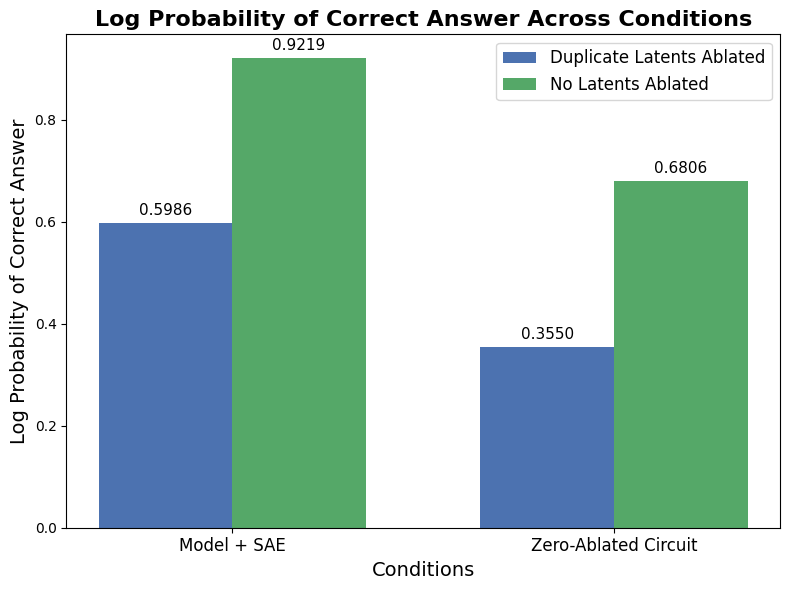

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Model + SAE', 'Zero-Ablated Circuit']
ablated_values = [model_dup_ablated, circuit_dup_ablated]
non_ablated_values = [full_model_perf, full_circuit_perf]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width/2, ablated_values, width=bar_width, label='Duplicate Latents Ablated', color='#4C72B0')
bars2 = plt.bar(x + bar_width/2, non_ablated_values, width=bar_width, label='No Latents Ablated', color='#55A868')

# Title and labels
plt.title("Log Probability of Correct Answer Across Conditions", fontsize=16, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Log Probability of Correct Answer", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

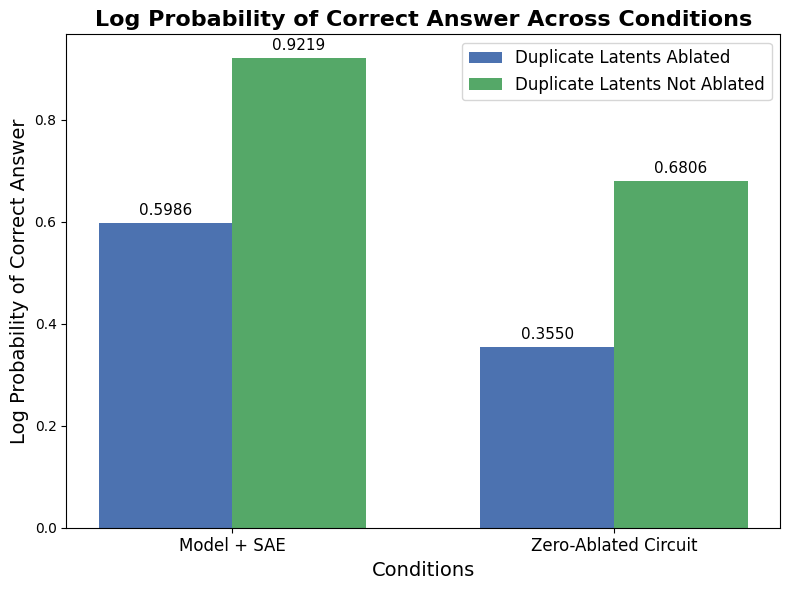

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Model + SAE', 'Zero-Ablated Circuit']
ablated_values = [model_dup_ablated, circuit_dup_ablated]
non_ablated_values = [full_model_perf, full_circuit_perf]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width/2, ablated_values, width=bar_width, label='Duplicate Latents Ablated', color='#4C72B0')
bars2 = plt.bar(x + bar_width/2, non_ablated_values, width=bar_width, label='Duplicate Latents Not Ablated', color='#55A868')

# Title and labels
plt.title("Log Probability of Correct Answer Across Conditions", fontsize=16, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Log Probability of Correct Answer", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

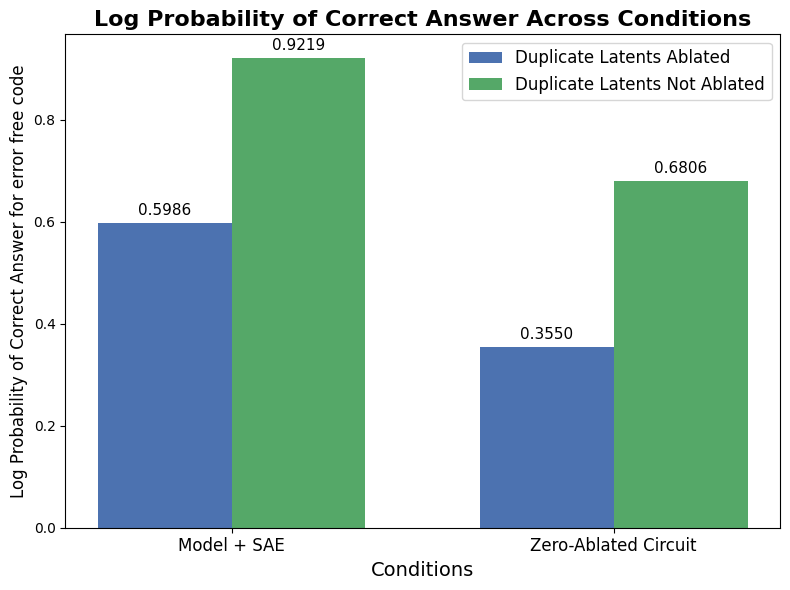

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Model + SAE', 'Zero-Ablated Circuit']
ablated_values = [model_dup_ablated, circuit_dup_ablated]
non_ablated_values = [full_model_perf, full_circuit_perf]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width/2, ablated_values, width=bar_width, label='Duplicate Latents Ablated', color='#4C72B0')
bars2 = plt.bar(x + bar_width/2, non_ablated_values, width=bar_width, label='Duplicate Latents Not Ablated', color='#55A868')

# Title and labels
plt.title("Log Probability of Correct Answer Across Conditions", fontsize=16, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Log Probability of Correct Answer for error free code", fontsize=12)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

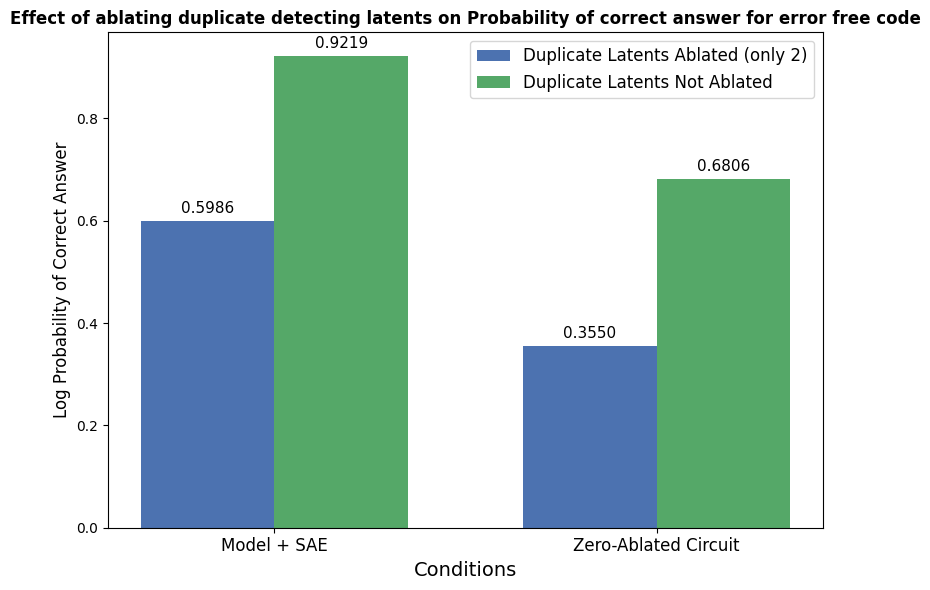

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Model + SAE', 'Zero-Ablated Circuit']
ablated_values = [model_dup_ablated, circuit_dup_ablated]
non_ablated_values = [full_model_perf, full_circuit_perf]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width/2, ablated_values, width=bar_width, label='Duplicate Latents Ablated (only 2)', color='#4C72B0')
bars2 = plt.bar(x + bar_width/2, non_ablated_values, width=bar_width, label='Duplicate Latents Not Ablated', color='#55A868')

# Title and labels
plt.title("Effect of ablating duplicate detecting latents on Probability of correct answer for error free code", fontsize=12, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Log Probability of Correct Answer", fontsize=12)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

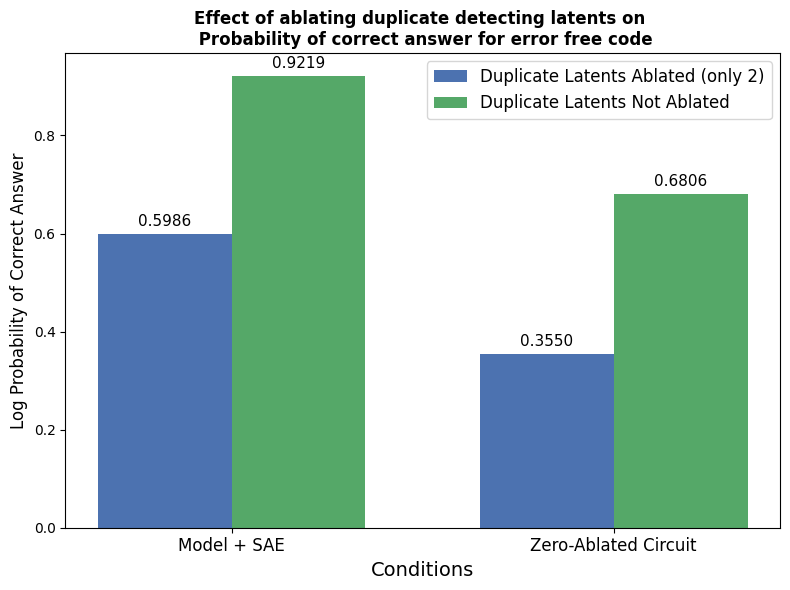

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Model + SAE', 'Zero-Ablated Circuit']
ablated_values = [model_dup_ablated, circuit_dup_ablated]
non_ablated_values = [full_model_perf, full_circuit_perf]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width/2, ablated_values, width=bar_width, label='Duplicate Latents Ablated (only 2)', color='#4C72B0')
bars2 = plt.bar(x + bar_width/2, non_ablated_values, width=bar_width, label='Duplicate Latents Not Ablated', color='#55A868')

# Title and labels
plt.title("Effect of ablating duplicate detecting latents on \n Probability of correct answer for error free code", fontsize=12, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Log Probability of Correct Answer", fontsize=12)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

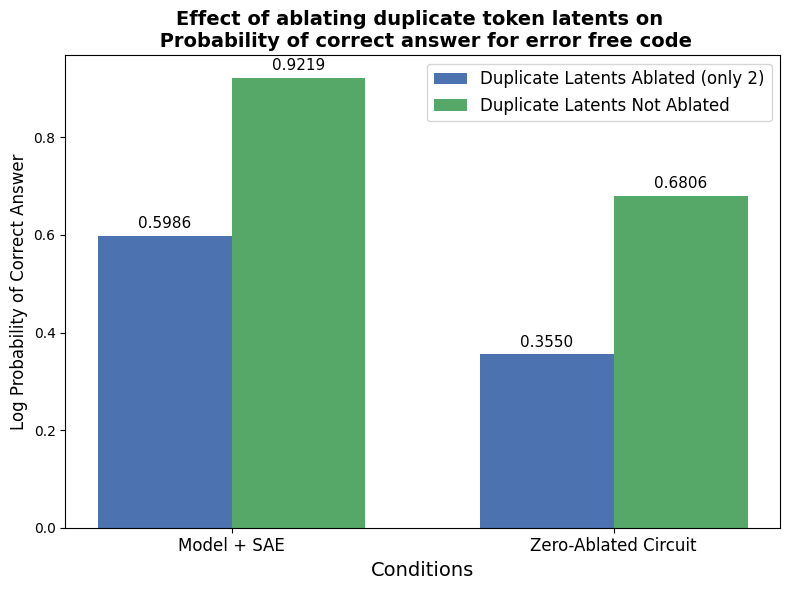

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Model + SAE', 'Zero-Ablated Circuit']
ablated_values = [model_dup_ablated, circuit_dup_ablated]
non_ablated_values = [full_model_perf, full_circuit_perf]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width/2, ablated_values, width=bar_width, label='Duplicate Latents Ablated (only 2)', color='#4C72B0')
bars2 = plt.bar(x + bar_width/2, non_ablated_values, width=bar_width, label='Duplicate Latents Not Ablated', color='#55A868')

# Title and labels
plt.title("Effect of ablating duplicate token latents on \n Probability of correct answer for error free code", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Log Probability of Correct Answer", fontsize=12)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

In [20]:
def run_with_saes_filtered_cache(tokens, filtered_ids, model, saes):
    with torch.no_grad():  # Global no_grad for performance
        
        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Equivalent to unsqueeze(-1)

        sae_outs = {}
        
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Apply torch.where only if mask_expanded has True values
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_outs


def run_with_saes_latent_op_patch(new_tokens, filtered_ids, model, saes, cache, dict_feats):
   # Ensure tokens are a torch.Tensor
   if not isinstance(new_tokens, torch.Tensor):
       new_tokens = torch.tensor(new_tokens).to(model.cfg.device)  # Move to the device of the model

   # Create a mask where True indicates positions to modify
   mask = torch.ones_like(new_tokens, dtype=torch.bool)
   for token_id in filtered_ids:
       mask &= new_tokens != token_id

   # Expand the mask once, so it matches the shape [batch_size, seq_len, 1]
   mask_expanded = mask.unsqueeze(-1)  # Expand to allow broadcasting
   mask_expanded = mask_expanded.to(model.cfg.device)  # Move the mask to the same device as the model
   # For each SAE, add the appropriate hook
   for sae in saes:
       hook_point = sae.cfg.hook_name

       # Define the filtered hook function (optimized)
       def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
           # Apply the SAE only where mask_expanded is True
           enc_sae = sae.encode(act)  # Call the SAE once
          
           if hook.name in cache and hook.name in dict_feats:
               prev_sae = cache[hook.name].to(device)   # Get cached activations from the cache
               feature_indices = dict_feats[hook.name]  # Get the feature indices to patch

               for feature_idx in range(sae.cfg.d_sae):
                   if feature_idx in feature_indices:
                       enc_sae[:, :, feature_idx] = prev_sae[:, :, feature_idx]

           # After patching, decode the modified enc_sae
           modified_act = sae.decode(enc_sae)

           # In-place update where the mask is True
           updated_act = torch.where(mask_expanded, modified_act, act)

           return updated_act

       # Add the hook to the model
       model.add_hook(hook_point, filtered_hook, dir='fwd')

   # Run the model with the tokens (no gradients needed)
   with torch.no_grad():
       logits = model(new_tokens)

   # Reset the hooks after computation to free memory
   model.reset_hooks()

   return logits  # Return only the logits

def run_with_saes_latent_op_patch_cache(new_tokens, filtered_ids, model, saes, cache, dict_feats):
    with torch.no_grad():  # Global no_grad for efficiency

        # Ensure new_tokens is a tensor on the correct device
        new_tokens = torch.as_tensor(new_tokens, device=model.cfg.device)
        
        # Create mask in a vectorized way
        mask = ~torch.isin(new_tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]  # Expand dimensions directly
        
        # Cache hook names and feature indices outside the hook
        sae_hook_configs = [(sae.cfg.hook_name, sae, dict_feats.get(sae.cfg.hook_name, [])) for sae in saes]
        sae_outs = {}

        # Define and apply hooks
        for hook_name, sae, feature_indices in sae_hook_configs:
            def filtered_hook(act, hook, sae=sae, feature_indices=feature_indices, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                if hook.name in cache and feature_indices:
                    # Vectorized update of selected feature indices
                    enc_sae[:, :, feature_indices] = cache[hook.name][:, :, feature_indices].to(device) 

                sae_outs[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                
                # Only apply torch.where if needed
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_name, filtered_hook, dir='fwd')

        logits = model(new_tokens)
        model.reset_hooks()

    return logits, sae_outs
    
def run_with_saes_zero_ablation(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]

        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0

                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits


def run_with_saes_zero_ablation_cache(tokens, filtered_ids, model, saes, dict_feats):
    with torch.no_grad():  # Global no_grad for performance

        # Ensure tokens is on the correct device
        tokens = torch.as_tensor(tokens, device=model.cfg.device)

        # Vectorized mask creation
        mask = ~torch.isin(tokens, torch.tensor(filtered_ids, device=model.cfg.device))
        mask_expanded = mask[:, :, None]
        sae_out = {}
        # Define and add hooks
        for sae in saes:
            hook_point = sae.cfg.hook_name
            
            def filtered_hook(act, hook, sae=sae, mask_expanded=mask_expanded):
                enc_sae = sae.encode(act)
                
                if hook.name in dict_feats:
                    feature_indices = dict_feats[hook.name]
                    # Use advanced indexing to zero-out non-selected features
                    all_indices = torch.arange(sae.cfg.d_sae, device=model.cfg.device)
                    zero_indices = all_indices[~torch.isin(all_indices, torch.tensor(feature_indices, device=model.cfg.device))]
                    enc_sae[:, :, zero_indices] = 0
                sae_out[hook.name] = enc_sae.detach().cpu()
                modified_act = sae.decode(enc_sae)
                updated_act = torch.where(mask_expanded, modified_act, act) if mask_expanded.any() else act
                return updated_act
            
            model.add_hook(hook_point, filtered_hook, dir='fwd')
        
        logits = model(tokens)
        model.reset_hooks()
        
    return logits, sae_out

In [21]:
# H6.1 Ablating the duplicate detectors fully causes this feature to turn off
cleanup_cuda()
# duplicate token latents are cluster 0 for layer 7 
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(duplicate_latents))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(clean_tokens, filtered_ids, model, saes, mask)
L40_9682_activation = cache['blocks.40.hook_resid_post'][:, :, 9682]
# mean over first dim 
dim = 1
print("L40_9682_activation: ", L40_9682_activation.mean(dim))
# print("L40_9682_activation: ", L40_9682_activation.mean(dim))

L40_9682_activation:  tensor([10.5649,  7.4483,  7.5700,  8.4397,  8.0781,  9.6905,  8.0975,  7.3888,
         9.0793,  9.2164,  8.8424,  9.1940,  7.9052,  9.4851,  7.3796, 10.1126,
         7.9520,  8.1595,  9.5148,  8.5396,  7.5880,  8.3626,  7.9978,  7.9672,
         8.8936,  8.5862,  8.2442,  7.8753,  7.5966,  9.0262,  8.4767,  7.7726,
         8.8782,  8.6157,  7.9364,  9.0274,  8.5309,  9.1270,  7.8671,  8.1858,
         9.2372,  9.2605,  9.1337,  8.5466,  9.7697,  9.5461,  9.3325,  8.3938,
         8.3350,  9.6182])


In [22]:
# H6.1 Ablating the duplicate detectors fully causes this feature to turn off
cleanup_cuda()
# duplicate token latents are cluster 0 for layer 7 
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(duplicate_latents))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(clean_tokens, filtered_ids, model, saes, mask)
L40_9682_activation = cache['blocks.40.hook_resid_post'][:, :, 9682]
# mean over first dim 
dim = 0
print("L40_9682_activation: ", L40_9682_activation.mean(dim))
# print("L40_9682_activation: ", L40_9682_activation.mean(dim))

L40_9682_activation:  tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
        19.4912, 15.7402,  0.7002,  0.0000,  0.0000,  7.4549,  0.5123, 31.8292,
        35.5669,  0.8616,  0.0000,  1.3105, 15.7283, 19.1175, 42.3075, 41.1529,
         1.7598,  0.5222,  6.8831, 24.4488, 31.6671, 49.1148, 52.1590,  3.0378,
         3.5127, 19.5842, 21.4968, 20.3899, 16.8606, 25.2979,  8.0375,  2.1413,
        40.8161])


In [23]:
# H6.1 Ablating the duplicate detectors fully causes this feature to turn off
cleanup_cuda()
# duplicate token latents are cluster 0 for layer 7 
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(duplicate_latents))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(clean_tokens, filtered_ids, model, saes, mask)
L40_9682_activation = cache['blocks.40.hook_resid_post'][:, :, 9682]
# mean over first dim 
dim = 0
print("L40_9682_activation: ", L40_9682_activation.sum())
# print("L40_9682_activation: ", L40_9682_activation.mean(dim))

L40_9682_activation:  tensor(27975.1367)


In [24]:
# H6.1 Ablating the duplicate detectors fully causes this feature to turn off
cleanup_cuda()
# duplicate token latents are cluster 0 for layer 7 
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(duplicate_latents))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(clean_tokens, filtered_ids, model, saes, mask)
L40_9682_activation = cache['blocks.40.hook_resid_post'][:, :, 9682]
# mean over first dim 
dim = 0
print("L40_9682_activation: ", L40_9682_activation.sum())
# print("L40_9682_activation: ", L40_9682_activation.mean(dim))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(clean_tokens, filtered_ids, model, saes, filtered_mask)
L40_9682_activation = cache['blocks.40.hook_resid_post'][:, :, 9682]
print("L40_9682_activation: ", L40_9682_activation.sum())

del cache, L40_9682_activation
cleanup_cuda()

L40_9682_activation:  tensor(27975.1367)
L40_9682_activation:  tensor(27816.9727)


In [25]:
# H6.1 Ablating the duplicate detectors fully causes this feature to turn off
cleanup_cuda()
# duplicate token latents are cluster 0 for layer 7 
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(duplicate_latents))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, mask)
L40_9682_activation = cache['blocks.40.hook_resid_post'][:, :, 9682]
# mean over first dim 
dim = 0
print("L40_9682_activation: ", L40_9682_activation.sum())
# print("L40_9682_activation: ", L40_9682_activation.mean(dim))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, filtered_mask)
L40_9682_activation = cache['blocks.40.hook_resid_post'][:, :, 9682]
print("L40_9682_activation: ", L40_9682_activation.sum())

del cache, L40_9682_activation
cleanup_cuda()

L40_9682_activation:  tensor(29348.0879)
L40_9682_activation:  tensor(27730.5820)


In [26]:
# H6.1 Ablating the duplicate detectors fully causes this feature to turn off
cleanup_cuda()
# duplicate token latents are cluster 0 for layer 7 
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(duplicate_latents))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, mask)
L40_9682_activation = cache['blocks.40.hook_resid_post'][:, :, 9682].item().mean(0)
print("L40_9682_activation: ", L40_9682_activation)
# print("L40_9682_activation: ", L40_9682_activation.mean(dim))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, filtered_mask)
L40_9682_activation = cache['blocks.40.hook_resid_post'][:, :, 9682].item().mean(0)
print("L40_9682_activation: ", L40_9682_activation)

del cache, L40_9682_activation
cleanup_cuda()

RuntimeError: a Tensor with 3250 elements cannot be converted to Scalar

In [27]:
# H6.1 Ablating the duplicate detectors fully causes this feature to turn off
cleanup_cuda()
# duplicate token latents are cluster 0 for layer 7 
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(duplicate_latents))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, mask)
L40_9682_activation = list(cache['blocks.40.hook_resid_post'][:, :, 9682].mean(0))
print("L40_9682_activation: ", L40_9682_activation)
# print("L40_9682_activation: ", L40_9682_activation.mean(dim))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, filtered_mask)
L40_9682_activation = list(cache['blocks.40.hook_resid_post'][:, :, 9682].mean(0))
print("L40_9682_activation: ", L40_9682_activation)

del cache, L40_9682_activation
cleanup_cuda()

L40_9682_activation:  [tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(0.), tensor(19.4912), tensor(15.7402), tensor(0.7002), tensor(0.), tensor(0.), tensor(7.4549), tensor(0.5123), tensor(31.8292), tensor(35.5669), tensor(0.8616), tensor(0.), tensor(1.3105), tensor(15.7283), tensor(19.1175), tensor(42.3075), tensor(41.1529), tensor(1.7598), tensor(0.5222), tensor(6.8831), tensor(24.4488), tensor(31.6671), tensor(49.1148), tensor(52.1590), tensor(3.0378), tensor(3.5127), tensor(19.5842), tensor(21.4968), tensor(20.3899), tensor(16.8606), tensor(25.2979), tensor(12.6423), tensor(18.4067), tensor(47.4049)]
L40_9682_activation:  [tensor(0.), tensor(0.), tensor(0.)

In [28]:
clean_tokens.shape

torch.Size([50, 65])

In [29]:
# H6.1 Ablating the duplicate detectors fully causes this feature to turn off
cleanup_cuda()
# duplicate token latents are cluster 0 for layer 7 
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(duplicate_latents))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, mask)
L40_9682_activation_circuit = cache['blocks.40.hook_resid_post'][:, :, 9682].mean(0)
# print("L40_9682_activation: ", L40_9682_activation)
# print("L40_9682_activation: ", L40_9682_activation.mean(dim))

model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, filtered_mask)
L40_9682_activation_circuit_ablated = cache['blocks.40.hook_resid_post'][:, :, 9682].mean(0)
# print("L40_9682_activation: ", L40_9682_activation)

del cache
cleanup_cuda()

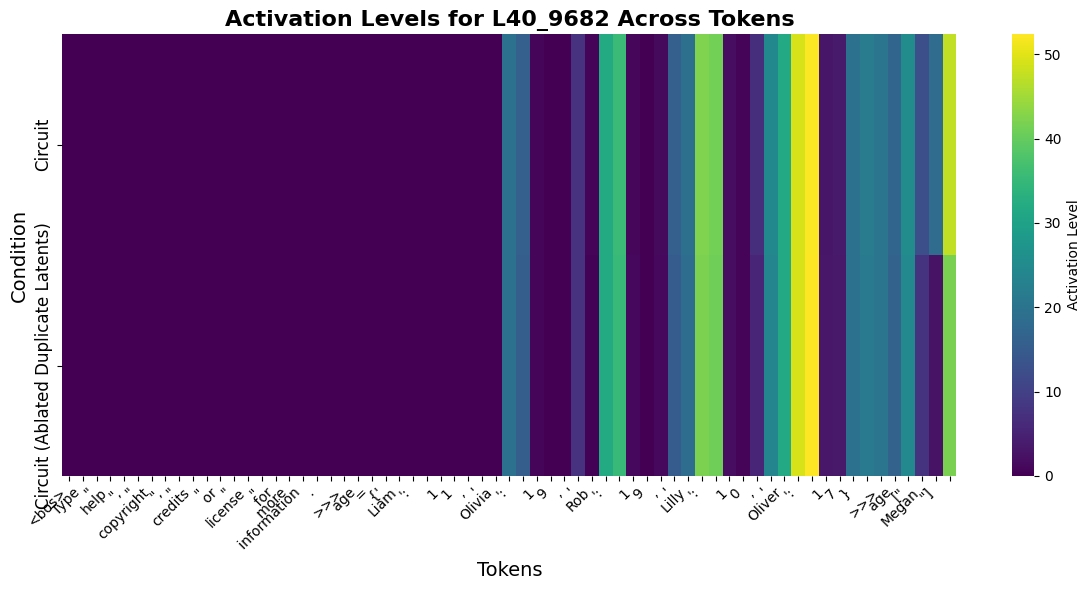

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Stack the two activations into a 2x65 array for plotting
activations = np.vstack([L40_9682_activation_circuit, L40_9682_activation_circuit_ablated])

# Generate token labels for x-axis
token_labels = model.to_str_tokens(clean_prompts[0])

# Set up the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    activations, 
    annot=False, 
    xticklabels=token_labels, 
    yticklabels=['Circuit', 'Circuit (Ablated Duplicate Latents)'], 
    cmap='viridis', 
    cbar_kws={'label': 'Activation Level'}
)

# Add titles and labels for clarity
plt.title("Activation Levels for L40_9682 Across Tokens", fontsize=16, weight='bold')
plt.xlabel("Tokens", fontsize=14)
plt.ylabel("Condition", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

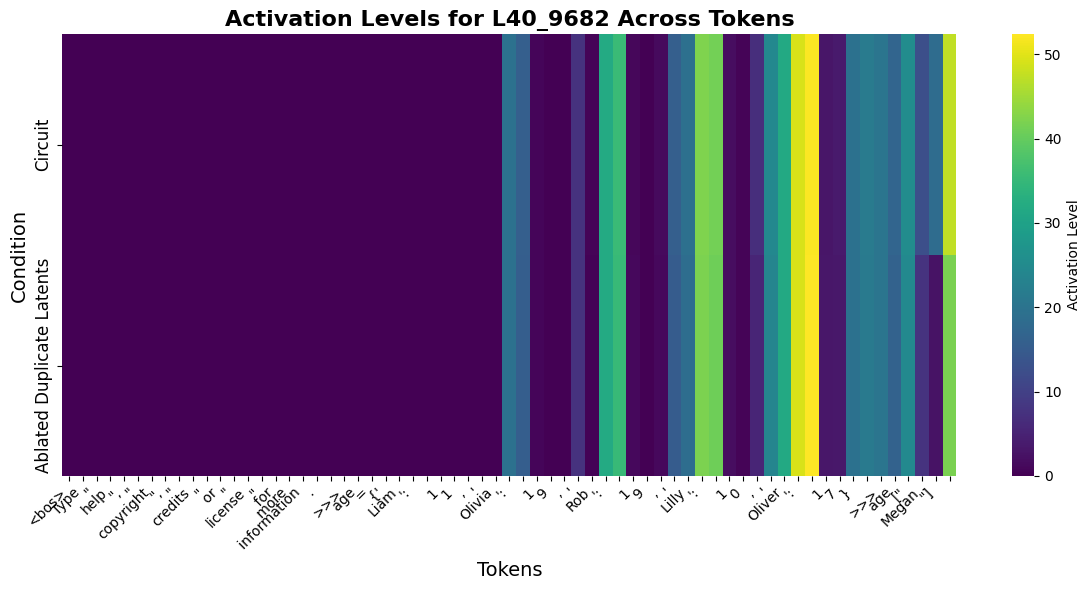

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Stack the two activations into a 2x65 array for plotting
activations = np.vstack([L40_9682_activation_circuit, L40_9682_activation_circuit_ablated])

# Generate token labels for x-axis
token_labels = model.to_str_tokens(clean_prompts[0])

# Set up the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    activations, 
    annot=False, 
    xticklabels=token_labels, 
    yticklabels=['Circuit', 'Ablated Duplicate Latents'], 
    cmap='viridis', 
    cbar_kws={'label': 'Activation Level'}
)

# Add titles and labels for clarity
plt.title("Activation Levels for L40_9682 Across Tokens", fontsize=16, weight='bold')
plt.xlabel("Tokens", fontsize=14)
plt.ylabel("Condition", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

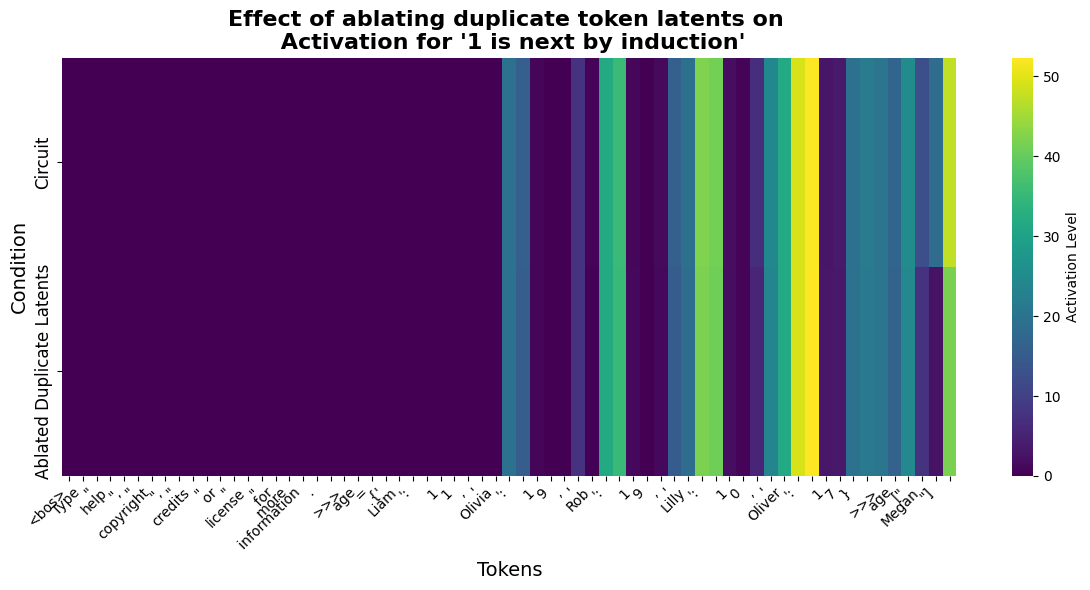

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Stack the two activations into a 2x65 array for plotting
activations = np.vstack([L40_9682_activation_circuit, L40_9682_activation_circuit_ablated])

# Generate token labels for x-axis
token_labels = model.to_str_tokens(clean_prompts[0])

# Set up the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    activations, 
    annot=False, 
    xticklabels=token_labels, 
    yticklabels=['Circuit', 'Ablated Duplicate Latents'], 
    cmap='viridis', 
    cbar_kws={'label': 'Activation Level'}
)

# Add titles and labels for clarity
plt.title("Effect of ablating duplicate token latents on \n Activation for '1 is next by induction'", fontsize=16, weight='bold')
plt.xlabel("Tokens", fontsize=14)
plt.ylabel("Condition", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

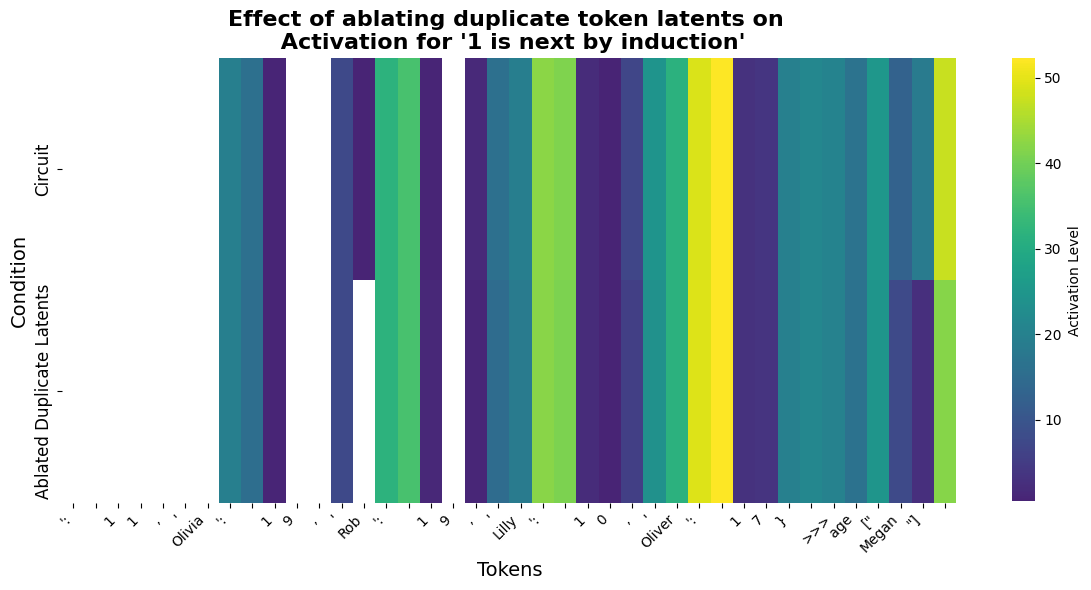

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

# Stack the two activations into a 2x65 array for plotting
activations = np.vstack([L40_9682_activation_circuit, L40_9682_activation_circuit_ablated])

# Slice the last 40 tokens and their activations
activations = activations[:, -40:]  # Selecting the last 40 tokens
token_labels = model.to_str_tokens(clean_prompts[0])[-40:] 

# Create a custom colormap: White for zero, then viridis for the rest
cmap = sns.color_palette("viridis", as_cmap=True)
cmap_with_white = ListedColormap(["white"] + list(cmap(np.linspace(0.1, 1, 256))))

# Set up the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    activations,
    annot=False,
    xticklabels=token_labels,
    yticklabels=['Circuit', 'Ablated Duplicate Latents'],
    cmap=cmap_with_white,
    cbar_kws={'label': 'Activation Level'},
    mask=(activations == 0)  # Mask zero values to ensure they are white
)

# Add titles and labels for clarity
plt.title("Effect of ablating duplicate token latents on \n Activation for '1 is next by induction'", fontsize=16, weight='bold')
plt.xlabel("Tokens", fontsize=14)
plt.ylabel("Condition", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

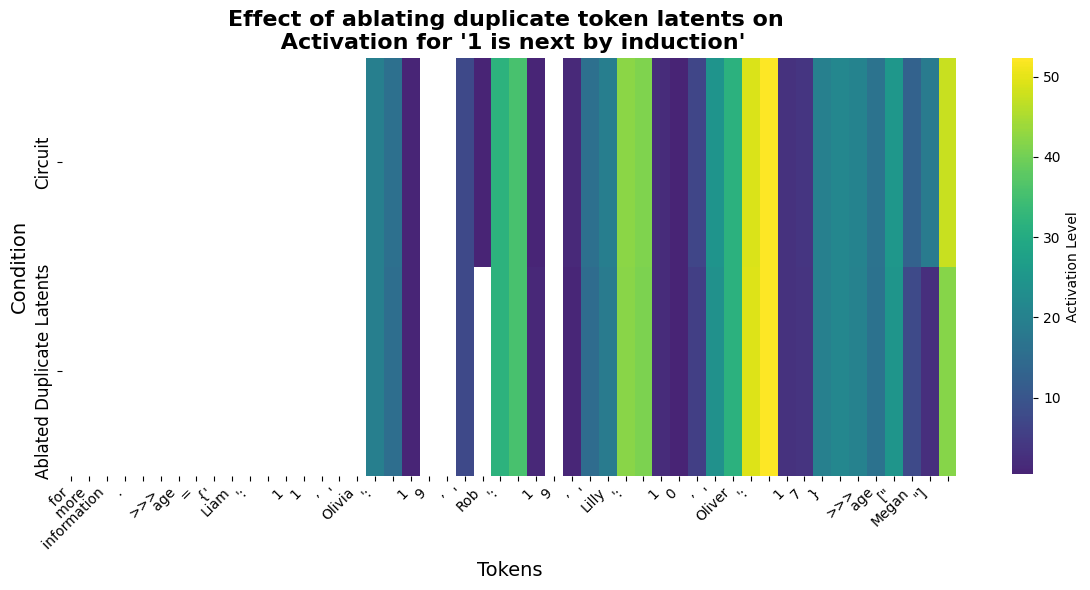

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

# Stack the two activations into a 2x65 array for plotting
activations = np.vstack([L40_9682_activation_circuit, L40_9682_activation_circuit_ablated])

# Slice the last 40 tokens and their activations
activations = activations[:, -50:]  # Selecting the last 40 tokens
token_labels = model.to_str_tokens(clean_prompts[0])[-50:] 

# Create a custom colormap: White for zero, then viridis for the rest
cmap = sns.color_palette("viridis", as_cmap=True)
cmap_with_white = ListedColormap(["white"] + list(cmap(np.linspace(0.1, 1, 256))))

# Set up the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    activations,
    annot=False,
    xticklabels=token_labels,
    yticklabels=['Circuit', 'Ablated Duplicate Latents'],
    cmap=cmap_with_white,
    cbar_kws={'label': 'Activation Level'},
    mask=(activations == 0)  # Mask zero values to ensure they are white
)

# Add titles and labels for clarity
plt.title("Effect of ablating duplicate token latents on \n Activation for '1 is next by induction'", fontsize=16, weight='bold')
plt.xlabel("Tokens", fontsize=14)
plt.ylabel("Condition", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

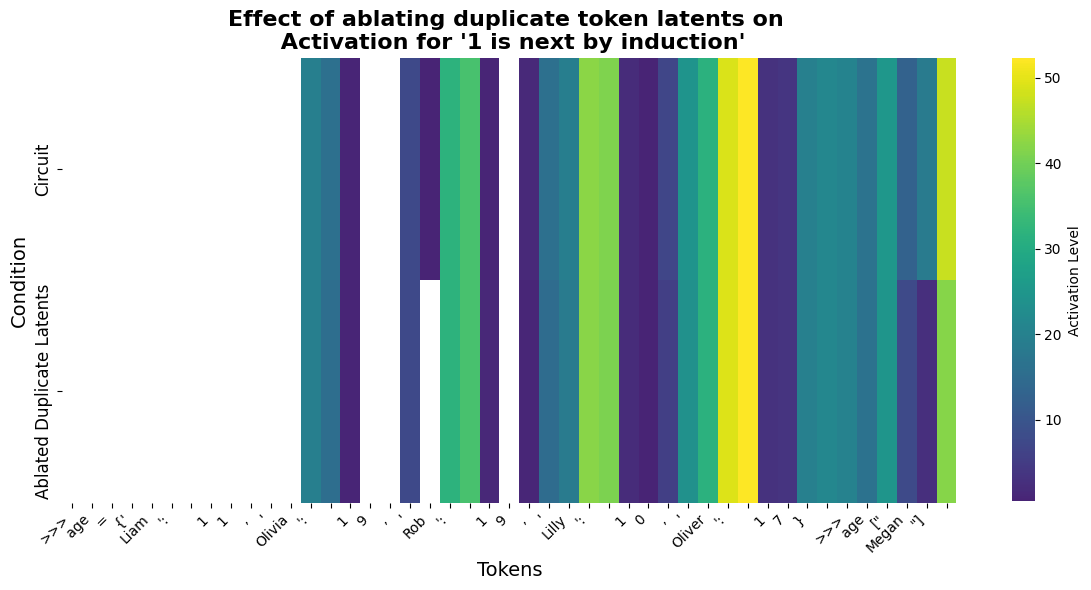

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

# Stack the two activations into a 2x65 array for plotting
activations = np.vstack([L40_9682_activation_circuit, L40_9682_activation_circuit_ablated])

# Slice the last 40 tokens and their activations
activations = activations[:, -45:]  # Selecting the last 40 tokens
token_labels = model.to_str_tokens(clean_prompts[0])[-45:] 

# Create a custom colormap: White for zero, then viridis for the rest
cmap = sns.color_palette("viridis", as_cmap=True)
cmap_with_white = ListedColormap(["white"] + list(cmap(np.linspace(0.1, 1, 256))))

# Set up the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    activations,
    annot=False,
    xticklabels=token_labels,
    yticklabels=['Circuit', 'Ablated Duplicate Latents'],
    cmap=cmap_with_white,
    cbar_kws={'label': 'Activation Level'},
    mask=(activations == 0)  # Mask zero values to ensure they are white
)

# Add titles and labels for clarity
plt.title("Effect of ablating duplicate token latents on \n Activation for '1 is next by induction'", fontsize=16, weight='bold')
plt.xlabel("Tokens", fontsize=14)
plt.ylabel("Condition", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

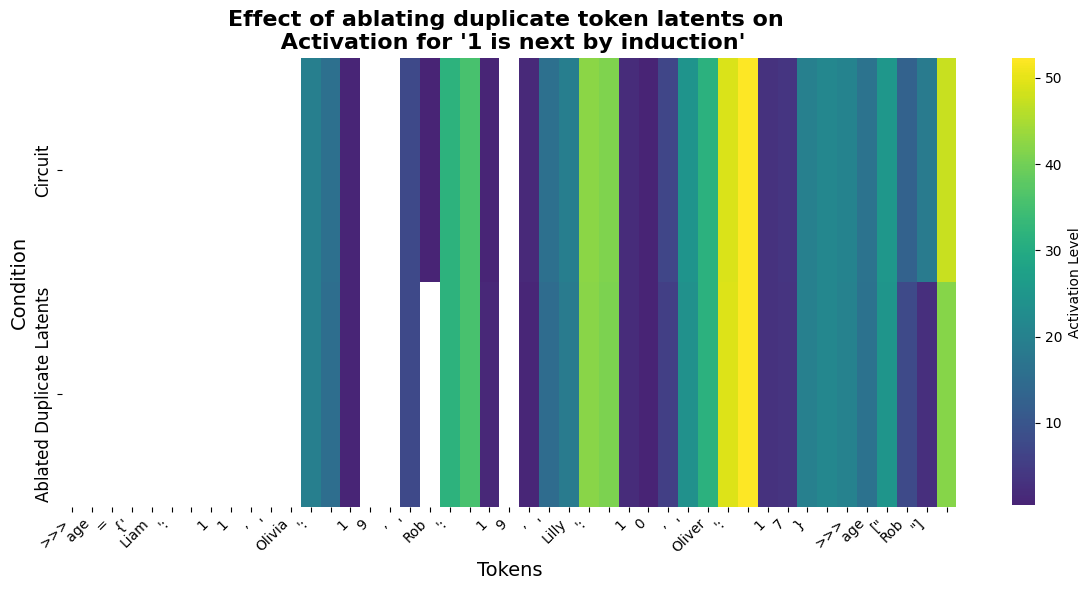

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

# Stack the two activations into a 2x65 array for plotting
activations = np.vstack([L40_9682_activation_circuit, L40_9682_activation_circuit_ablated])

# Slice the last 40 tokens and their activations
activations = activations[:, -45:]  # Selecting the last 40 tokens
token_labels = model.to_str_tokens(corr_prompts[0])[-45:] 

# Create a custom colormap: White for zero, then viridis for the rest
cmap = sns.color_palette("viridis", as_cmap=True)
cmap_with_white = ListedColormap(["white"] + list(cmap(np.linspace(0.1, 1, 256))))

# Set up the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    activations,
    annot=False,
    xticklabels=token_labels,
    yticklabels=['Circuit', 'Ablated Duplicate Latents'],
    cmap=cmap_with_white,
    cbar_kws={'label': 'Activation Level'},
    mask=(activations == 0)  # Mask zero values to ensure they are white
)

# Add titles and labels for clarity
plt.title("Effect of ablating duplicate token latents on \n Activation for '1 is next by induction'", fontsize=16, weight='bold')
plt.xlabel("Tokens", fontsize=14)
plt.ylabel("Condition", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

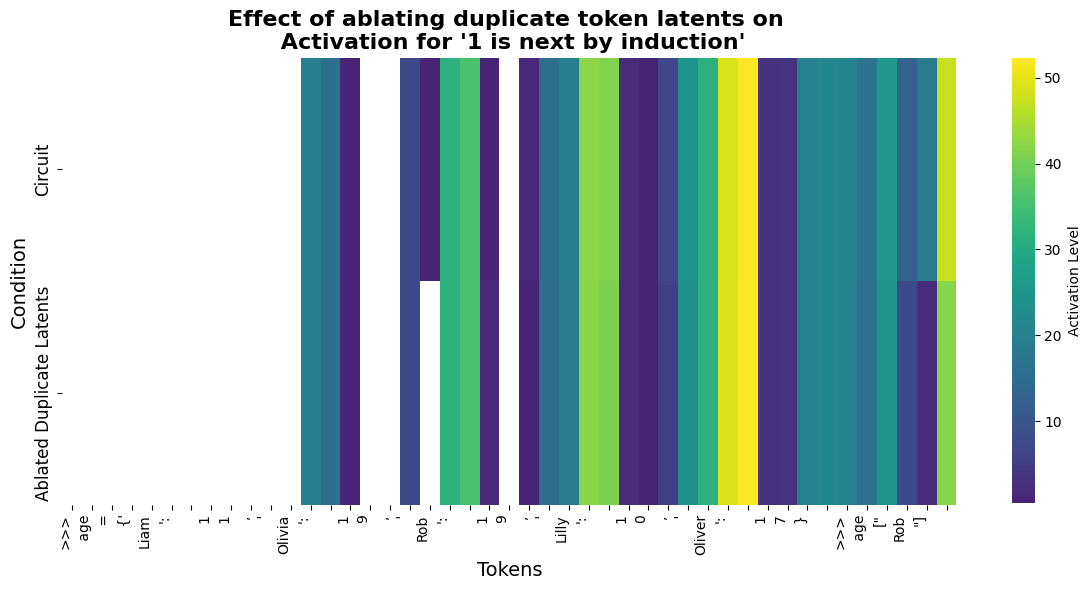

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

# Stack the two activations into a 2x65 array for plotting
activations = np.vstack([L40_9682_activation_circuit, L40_9682_activation_circuit_ablated])

# Slice the last 40 tokens and their activations
activations = activations[:, -45:]  # Selecting the last 40 tokens
token_labels = model.to_str_tokens(corr_prompts[0])[-45:] 

# Create a custom colormap: White for zero, then viridis for the rest
cmap = sns.color_palette("viridis", as_cmap=True)
cmap_with_white = ListedColormap(["white"] + list(cmap(np.linspace(0.1, 1, 256))))

# Set up the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    activations,
    annot=False,
    xticklabels=token_labels,
    yticklabels=['Circuit', 'Ablated Duplicate Latents'],
    cmap=cmap_with_white,
    cbar_kws={'label': 'Activation Level'},
    mask=(activations == 0)  # Mask zero values to ensure they are white
)

# Add titles and labels for clarity
plt.title("Effect of ablating duplicate token latents on \n Activation for '1 is next by induction'", fontsize=16, weight='bold')
plt.xlabel("Tokens", fontsize=14)
plt.ylabel("Condition", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right', fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

In [38]:
# Step 1: Define duplicate latents and create filtered mask
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(duplicate_latents))

# Step 2: Compute mean activation for full circuit without ablation
model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, mask)
L40_9682_activation_circuit = cache['blocks.40.hook_resid_post'][:, :, 9682].mean()
print("L40_9682_activation_circuit:", L40_9682_activation_circuit.item())

# Step 3: Compute mean activation for circuit with duplicate token latents ablated
model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, filtered_mask)
L40_9682_activation_circuit_ablated = cache['blocks.40.hook_resid_post'][:, :, 9682].mean()
print("L40_9682_activation_circuit_ablated:", L40_9682_activation_circuit_ablated.item())

# Step 4: Compute activations for Model + SAE (Full circuit without ablation)
model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, {})
model_sae_activation = cache['blocks.40.hook_resid_post'][:, :, 9682].mean()
print("Model + SAE Activation:", model_sae_activation.item())

# Step 5: Compute activations for Model + SAE with duplicate token latents ablated
fully_filtered_mask = {'blocks.7.hook_resid_post': list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))}
model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, fully_filtered_mask)
model_sae_activation_ablated = cache['blocks.40.hook_resid_post'][:, :, 9682].mean()
print("Model + SAE Activation (Ablated):", model_sae_activation_ablated.item())

# Cleanup after computation
del cache
cleanup_cuda()

L40_9682_activation_circuit: 9.030180931091309
L40_9682_activation_circuit_ablated: 8.532486915588379
Model + SAE Activation: 4.404298305511475
Model + SAE Activation (Ablated): 3.9240663051605225


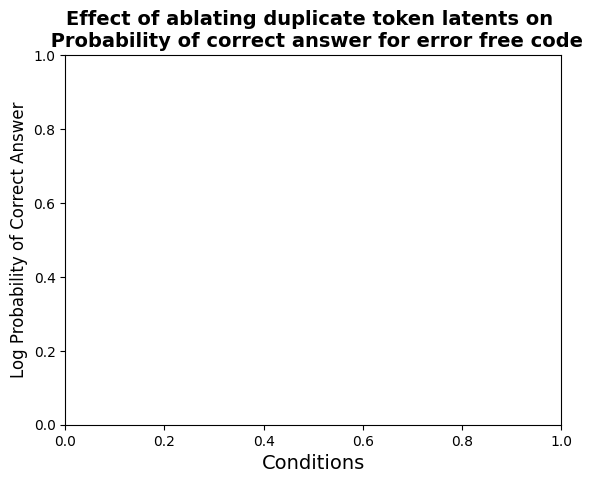

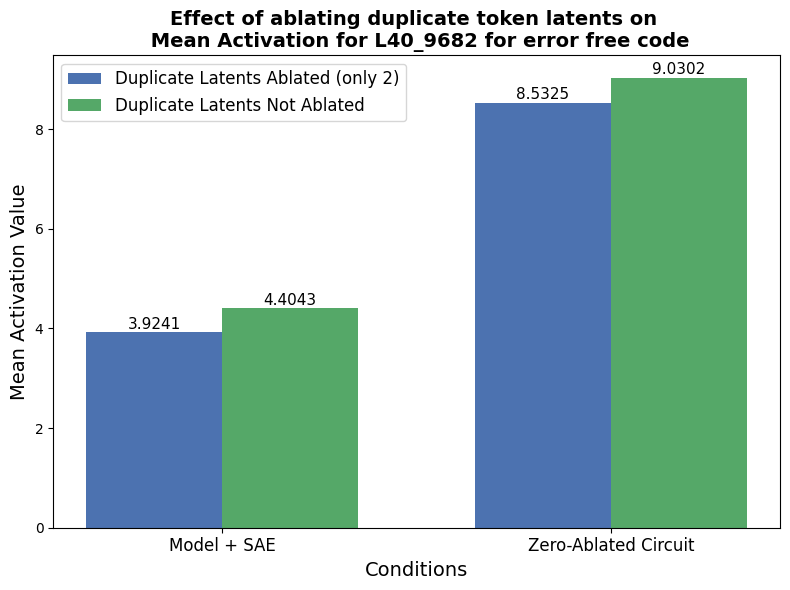

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these with the computed scalar values
circuit_activation = L40_9682_activation_circuit.item()
circuit_activation_ablated = L40_9682_activation_circuit_ablated.item()
model_sae_activation = model_sae_activation.item()
model_sae_activation_ablated = model_sae_activation_ablated.item()

# Define the labels and values
conditions = ['Model + SAE', 'Zero-Ablated Circuit']
ablated_values = [model_sae_activation_ablated, circuit_activation_ablated]
non_ablated_values = [model_sae_activation, circuit_activation]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35



# Title and labels
plt.title("Effect of ablating duplicate token latents on \n Probability of correct answer for error free code", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Log Probability of Correct Answer", fontsize=12)

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width / 2, ablated_values, width=bar_width, label='Duplicate Latents Ablated (only 2)', color='#4C72B0')
bars2 = plt.bar(x + bar_width / 2, non_ablated_values, width=bar_width, label='Duplicate Latents Not Ablated', color='#55A868')

# Title and labels
plt.title("Effect of ablating duplicate token latents on \n Mean Activation for L40_9682 for error free code", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Mean Activation Value", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Replace these with the computed scalar values
circuit_activation = L40_9682_activation_circuit.item()
circuit_activation_ablated = L40_9682_activation_circuit_ablated.item()
model_sae_activation = model_sae_activation.item()
model_sae_activation_ablated = model_sae_activation_ablated.item()

# Define the labels and values
conditions = ['Model + SAE', 'Zero-Ablated Circuit']
ablated_values = [model_sae_activation_ablated, circuit_activation_ablated]
non_ablated_values = [model_sae_activation, circuit_activation]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width / 2, ablated_values, width=bar_width, label='Duplicate Latents Ablated (only 2)', color='#4C72B0')
bars2 = plt.bar(x + bar_width / 2, non_ablated_values, width=bar_width, label='Duplicate Latents Not Ablated', color='#55A868')

# Title and labels
plt.title("Effect of ablating duplicate token latents on \n Mean Activation for L40_9682 for error free code", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Mean Activation Value", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

AttributeError: 'float' object has no attribute 'item'

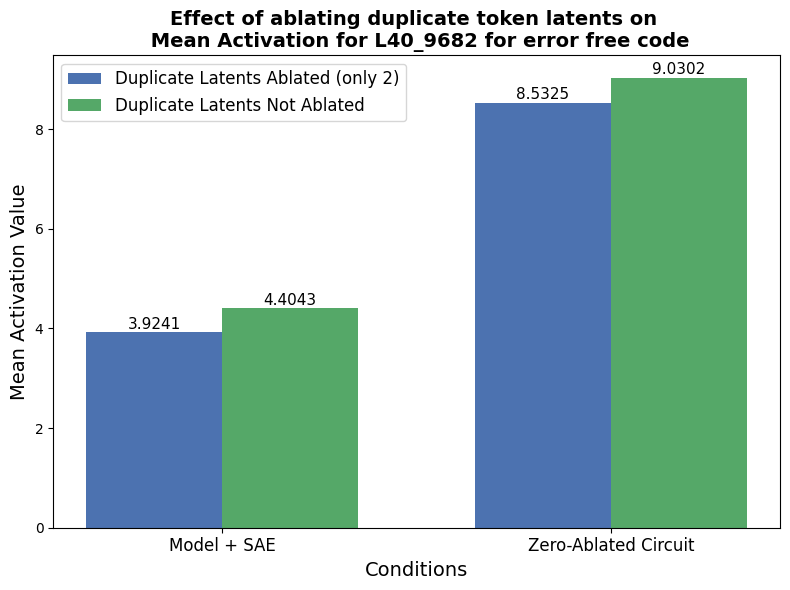

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# # Replace these with the computed scalar values
# circuit_activation = L40_9682_activation_circuit.item()
# circuit_activation_ablated = L40_9682_activation_circuit_ablated.item()
# model_sae_activation = model_sae_activation.item()
# model_sae_activation_ablated = model_sae_activation_ablated.item()

# Define the labels and values
conditions = ['Model + SAE', 'Zero-Ablated Circuit']
ablated_values = [model_sae_activation_ablated, L40_9682_activation_circuit_ablated.item()]
non_ablated_values = [model_sae_activation, L40_9682_activation_circuit.item()]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width / 2, ablated_values, width=bar_width, label='Duplicate Latents Ablated (only 2)', color='#4C72B0')
bars2 = plt.bar(x + bar_width / 2, non_ablated_values, width=bar_width, label='Duplicate Latents Not Ablated', color='#55A868')

# Title and labels
plt.title("Effect of ablating duplicate token latents on \n Mean Activation for L40_9682 for error free code", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Mean Activation Value", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()

In [42]:
# Step 1: Define duplicate latents and create filtered mask
duplicate_latents = cluster_results['blocks.7.hook_resid_post']['sum_clusters']['0']

filtered_mask = mask.copy()
filtered_mask['blocks.7.hook_resid_post'] = list(set(mask['blocks.7.hook_resid_post']) - set(duplicate_latents))

# Step 2: Compute mean activation for full circuit without ablation
model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, mask)
L40_9682_activation_circuit = cache['blocks.40.hook_resid_post'][:, -3:, 9682].mean().item()
print("L40_9682_activation_circuit:", L40_9682_activation_circuit)

# Step 3: Compute mean activation for circuit with duplicate token latents ablated
model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, filtered_mask)
L40_9682_activation_circuit_ablated = cache['blocks.40.hook_resid_post'][:, -3:, 9682].mean().item()
print("L40_9682_activation_circuit_ablated:", L40_9682_activation_circuit_ablated)

# Step 4: Compute activations for Model + SAE (Full circuit without ablation)
model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, {})
model_sae_activation = cache['blocks.40.hook_resid_post'][:, -3:, 9682].mean().item()
print("Model + SAE Activation:", model_sae_activation)

# Step 5: Compute activations for Model + SAE with duplicate token latents ablated
fully_filtered_mask = {'blocks.7.hook_resid_post': list(set(range(saes[0].cfg.d_sae)) - set(duplicate_latents))}
model.reset_hooks()
_, cache = run_with_saes_zero_ablation_cache(corr_tokens, filtered_ids, model, saes, fully_filtered_mask)
model_sae_activation_ablated = cache['blocks.40.hook_resid_post'][:, -3:, 9682].mean().item()
print("Model + SAE Activation (Ablated):", model_sae_activation_ablated)

# Cleanup after computation
del cache
cleanup_cuda()

L40_9682_activation_circuit: 26.15130615234375
L40_9682_activation_circuit_ablated: 17.381084442138672
Model + SAE Activation: 34.29997253417969
Model + SAE Activation (Ablated): 24.061647415161133


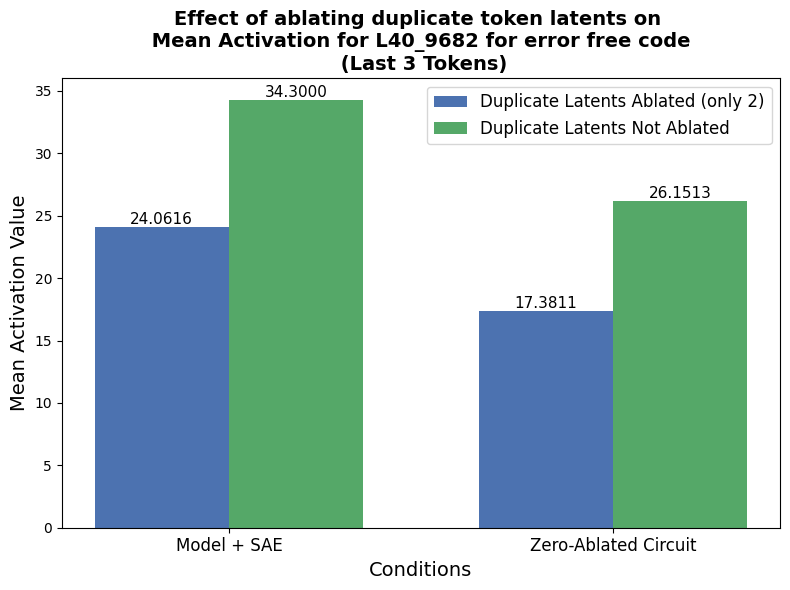

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Define the labels and values
conditions = ['Model + SAE', 'Zero-Ablated Circuit']
ablated_values = [model_sae_activation_ablated, L40_9682_activation_circuit_ablated]
non_ablated_values = [model_sae_activation, L40_9682_activation_circuit]

# Bar positions
x = np.arange(len(conditions))

# Width for each bar in a group
bar_width = 0.35

# Plotting
plt.figure(figsize=(8, 6))
bars1 = plt.bar(x - bar_width / 2, ablated_values, width=bar_width, label='Duplicate Latents Ablated (only 2)', color='#4C72B0')
bars2 = plt.bar(x + bar_width / 2, non_ablated_values, width=bar_width, label='Duplicate Latents Not Ablated', color='#55A868')

# Title and labels
plt.title("Effect of ablating duplicate token latents on \n Mean Activation for L40_9682 for error free code \n (Last 3 Tokens)", fontsize=14, weight='bold')
plt.xlabel("Conditions", fontsize=14)
plt.ylabel("Mean Activation Value", fontsize=14)

# Set x-axis tick positions and labels
plt.xticks(x, conditions, fontsize=12)

# Adding legend
plt.legend(fontsize=12)

# Display the values on top of the bars
for bars in [bars1, bars2]:
    for bar in bars:
        yval = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2, 
            yval + 0.01, 
            f"{yval:.4f}", 
            ha='center', 
            va='bottom', 
            fontsize=11
        )

plt.tight_layout()
plt.show()